# Resume Classification using TF-IDF
Jiayao Li

In [61]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [144]:
import re

from io import StringIO

import string

import numpy as np
import pandas as pd

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  
stop_words = stopwords.words('english')

In [63]:
df = pd.read_csv('/content/UpdatedResumeDataSet.csv')
df.head()
#source: https://www.kaggle.com/datasets/jillanisofttech/updated-resume-dataset

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


## 0. A visualized overview of the distribution of each category

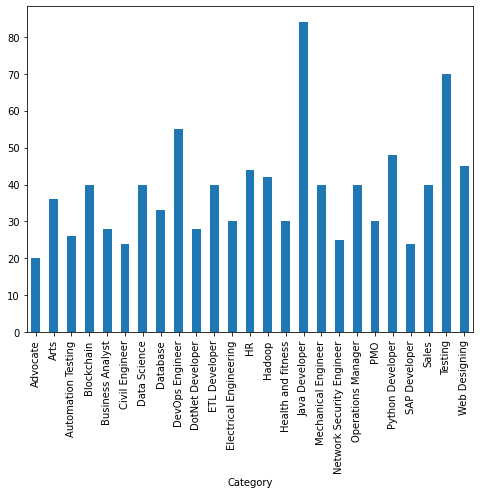

In [83]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Category').Resume.count().plot.bar(ylim=0)
plt.show()

## 1. Data Preprocessing

### 1.1 Text Cleansing

In [130]:
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

In [65]:
def clean(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
    text = re.sub(r"http\S+", "",text)
    html=re.compile(r'<.*?>')
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'')
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    text = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text)
    return text

In [66]:
df['Resume'] = df['Resume'].apply(lambda x: clean(x))

In [74]:
df.head()

,Category,Resume
0,Data Science,"skill programming language python pandas, nump..."
1,Data Science,education detail may may uit rgpv data scienti...
2,Data Science,"area interest deep learning, control system de..."
3,Data Science,skill r python sap hana tableau sap hana sql s...
4,Data Science,"education detail mca ymcaust, faridabad, harya..."


### 1.2 Category to vec

In [131]:
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
df.head()

,Category,Resume,category_id
0,Data Science,"skill programming language python pandas, nump...",0
1,Data Science,education detail may may uit rgpv data scienti...,0
2,Data Science,"area interest deep learning, control system de...",0
3,Data Science,skill r python sap hana tableau sap hana sql s...,0
4,Data Science,"education detail mca ymcaust, faridabad, harya...",0


### 1.3 TF-IDF Vectorizer

In [93]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Resume).toarray()
labels = df.category_id
features.shape

(962, 25841)

### 1.4 Visualizing the most correlated terms for each category

In the following format:

--- JOB CATEGORY ---

<1st correlated unigram>

<2nd correlated unigram>

<1st correlated bigram>

<2nd correlated bigram>


In [103]:
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]

  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

  print('---',Category.upper(),'---')
  print('\n'.join(unigrams[-2:]))
  print('\n'.join(bigrams[-2:]))
  print()

--- ADVOCATE ---
law
advocate
university advocate
advocate skill

--- ARTS ---
karate
art
art craft
drawing art

--- AUTOMATION TESTING ---
testng
selenium
automation testing
manual automation

--- BLOCKCHAIN ---
ethereum
blockchain
smart contract
blockchain developer

--- BUSINESS ANALYST ---
mailing
analyst
business analyst
analyst business

--- CIVIL ENGINEER ---
construction
civil
site engineer
civil engineer

--- DATA SCIENCE ---
deep
learning
machine learning
data science

--- DATABASE ---
administrator
rman
database administration
database administrator

--- DEVOPS ENGINEER ---
rfid
devops
size role
devops engineer

--- DOTNET DEVELOPER ---
aspnet
dot
net developer
dot net

--- ETL DEVELOPER ---
informatica
etl
knowledge yes
etl developer

--- ELECTRICAL ENGINEERING ---
fighting
electrical
course week
power plant

--- HR ---
mba
hr
university hr
hr skill

--- HADOOP ---
hive
hadoop
map reduce
hadoop developer

--- HEALTH AND FITNESS ---
nutrition
fitness
health fitness
fitness g

## 2. Classification

### 2.1 Train-test split

In [188]:
X_train, X_test , y_train, y_test = train_test_split(df['Resume'],
                                                     df['Category'],
                                                     random_state=0)

### 2.2 Using TF-IDF for feature extraction

In [189]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)

### 2.3 Multinomial Naive Bayes as classifier

In [190]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

### 2.4 Manual Testing

In [191]:
Resume_example_0 = ['I am skilled in python, machine learning, data mining, data structure and statistics.']
print(clf.predict(vectorizer.transform(Resume_example_0)))

['Data Science']


In [192]:
Resume_example_1 = ['I have 3 years of experience in trading bitcoin, ethereum, and I am a big fan of nft.']
print(clf.predict(vectorizer.transform(Resume_example_1)))

['Blockchain']


In [198]:
from random import randrange
seed = randrange(len(df))

Resume_example_2 = [df['Resume'][seed]]
test2_result = clf.predict(vectorizer.transform(Resume_example_2))[0]
print('Expected:', df['Category'][seed])
print('Prediction:', test2_result)

Expected: SAP Developer
Prediction: SAP Developer


### 2.5 Accuracy

In [199]:
y_pred_test = clf.predict(count_vect.transform(X_test))
accuracy_score(y_test, y_pred_test)

0.8838174273858921

### 2.6 Random Forest as classifier

In [223]:
clf = RandomForestClassifier().fit(X_train_tfidf, y_train)

### 2.7 Accuracy

In [224]:
y_pred_test = clf.predict(count_vect.transform(X_test))
accuracy_score(y_test, y_pred_test)

0.970954356846473

## 3. Result

As shown above, using TF-IDF to extract features in resume classication leads to a satisfactory accuracy.

However, accuracy is not the only measure of a model, especially when the dataset is imbalanced as shown in section 0. In addition, the size of the dataset might be too small to make a conclusion with confidence.